In [ ]:
import numpy as np
import PcmPy as pcm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import os
from scipy import stats

# Load the data
mat = scipy.io.loadmat(os.path.join('analysis','hd1_glm_betas.mat'))
glm_betas = mat
# glm_betas = glm_betas[0,0]
# glm_betas['beta'].shape
# checking the imported structure fields:
# print(glm_betas.dtype.names)

# hem         = {'lh','rh'};
# hemName     = {'LeftHem','RightHem'};
# regname     = {'S1','M1','PMd','PMv','SMA','V12','SPLa','SPLp'};

glm_info = pd.read_csv(os.path.join('analysis','hd1_glm_info.tsv'), sep='\t')

In [12]:
glm_info[glm_info['hand']==2]['run'].values.flatten()

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8])

## Estimating reliability of the data

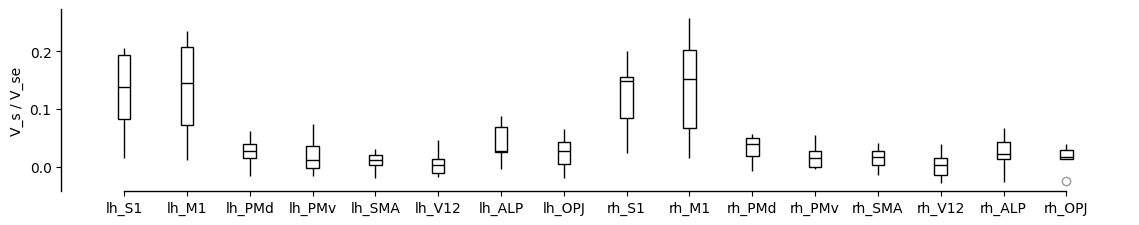

In [18]:
from utils import dataset as ds
import importlib
importlib.reload(ds)

region_names = ['lh_S1','lh_M1','lh_PMd','lh_PMv','lh_SMA','lh_V12','lh_ALP','lh_OPJ',
                'rh_S1','rh_M1','rh_PMd','rh_PMv','rh_SMA','rh_V12','rh_ALP','rh_OPJ']
region = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

hand = [1,2]
snr = []
# the variability in the contralateral region:
for h in hand:
    if h == 1:
        tmp_region = region[:8]
    elif h == 2:
        tmp_region = region[8:]
    for reg in tmp_region:
        reg_idx = (glm_betas['region']==reg).flatten()
        beta = glm_betas['beta'][reg_idx] / np.sqrt(glm_betas['ResMs'][reg_idx])
        beta = beta.T
        subj_vec = glm_betas['sn'][reg_idx].flatten()
        
        partition_vec = glm_info[glm_info['hand']==h]['run'].values.flatten()
        cond_vec = glm_info[glm_info['hand']==h]['digit'].values.flatten()
        
        v_s, v_se = ds.within_subj_var(data = beta, partition_vec=partition_vec, cond_vec=cond_vec, subj_vec=subj_vec, subtract_mean=True)
        snr.extend(v_s / v_se)

region_indicator = np.repeat(np.array(region),np.unique(subj_vec).shape[0])
snr = np.array(snr)

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(35*cm, 6*cm))

# Define custom properties for the box plot
boxprops = dict(edgecolor='#000000', linewidth=1)
whiskerprops = dict(color='#000000', linewidth=1)
capprops = dict(visible=False)  # Remove the caps
medianprops = dict(color='#000000', linewidth=1)

sns.boxplot(x=region_indicator, y=snr, dodge=True, width=0.2, color='#ffffff',
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

ax.set_xlim([-1, 16])
ax.set_xticks(np.arange(0,16))
ax.set_xticklabels(region_names)
ax.set_ylabel('V_s / V_se')

# Make it pretty:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.spines["left"].set_bounds(ax.get_ylim()[0], ax.get_ylim()[-1])
ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

plt.savefig(os.path.join('figures','cpd_snr.pdf'), format='pdf', bbox_inches='tight')

plt.show()